# Ingestion & Preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

#Viz
import seaborn as sns
import matplotlib.pyplot as plt

#EDA
import xgboost as xgb
import lightgbm as lgb

#from statlearning import plot_dist
#from statlearning import plot_regressions
#from statlearning import plot_coefficients
#from statlearning import plot_feature_importance
#from mpl_toolkits.basemap import Basemap

#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
#from mlxtend.regressor import StackingCVRegressor

In [2]:
df_train = pd.read_csv('boston_listings.csv',encoding ='ISO-8859-1')

In [3]:
df_train.head()

,id,name,summary,access,interaction,house_rules,host_id,host_since,host_location,host_response_time,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month
0,3781,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,Guests solely occupy the 1 floor apartment wit...,We sometimes travel. Always available via: mob...,"No pets, no smoking.",4804,2008/12/3,Massachusetts,within a few hours,...,10.0,10.0,10.0,10,t,NaN,f,f,super_strict_30,0.28
1,5506,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...",You get full access to the guest room with pri...,"We give guests privacy, but we are available ...",No Smoking in the Building.,8229,2009/2/19,"Boston, Massachusetts, United States",within an hour,...,10.0,10.0,9.0,10,t,Exempt: This listing is a unit that has contra...,t,f,strict_14_with_grace_period,0.79
2,6695,$99 Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Full Private apartment. 1 bedroom, kitchen, ...",NaN,No Smoking in the Building.,8229,2009/2/19,"Boston, Massachusetts, United States",within an hour,...,10.0,10.0,9.0,10,t,STR-404620,t,f,strict_14_with_grace_period,0.88
3,8789,Curved Glass Studio/1bd facing Park,"Bright, 1 bed with curved glass windows facing...",Guests have access to the full unit,I'm available for questions and/or issues.,NaN,26988,2009/7/22,"Boston, Massachusetts, United States",within a few hours,...,10.0,10.0,10.0,9,t,NaN,f,f,strict_14_with_grace_period,0.35
4,10730,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Guests have access to everything in the unit.,I'm available as needed.,"NO SMOKING, NO PETS. $100 move-in fee payable ...",26988,2009/7/22,"Boston, Massachusetts, United States",within a few hours,...,10.0,10.0,10.0,9,t,NaN,f,f,strict_14_with_grace_period,0.24


In [4]:
df_train['price']

0              $125.00 
1              $145.00 
2              $169.00 
3               $99.00 
4              $150.00 
             ...       
3840            $58.00 
3841           $150.00 
3842    Entire home/apt
3843            $50.00 
3844            $68.00 
Name: price, Length: 3845, dtype: object

In [5]:
df_train.isnull().sum()

id                                0
name                              0
summary                          80
access                         1633
interaction                    1252
house_rules                     988
host_id                           2
host_since                        2
host_location                     5
host_response_time              559
host_response_rate              559
host_acceptance_rate            260
host_is_superhost                 1
host_neighbourhood              219
host_total_listings_count         1
host_verifications                1
host_identity_verified            1
neighbourhood                     1
neighbourhood_cleansed            1
zipcode                          14
latitude                          0
longitude                         0
is_location_exact                 0
property_type                     1
room_type                         0
accommodates                      0
bathrooms                         3
bedrooms                    

In [6]:
df_train = df_train.drop(['id','name','host_since','host_location','host_verifications','summary','access','interaction','house_rules','host_id','zipcode',
                          'requires_license','license','review_scores_rating','review_scores_accuracy',
                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                         'review_scores_location','review_scores_value','reviews_per_month','host_response_time',
                         'host_response_rate','host_acceptance_rate','host_neighbourhood','host_is_superhost','host_neighbourhood'],axis = 1)

In [7]:
df_train.isnull().sum()

host_total_listings_count      1
host_identity_verified         1
neighbourhood                  1
neighbourhood_cleansed         1
latitude                       0
longitude                      0
is_location_exact              0
property_type                  1
room_type                      0
accommodates                   0
bathrooms                      3
bedrooms                       4
beds                          20
bed_type                       1
amenities_dict                 0
price                          1
cleaning_fee                 396
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              1
instant_bookable               4
is_business_travel_ready       4
cancellation_policy            3
dtype: int64

In [8]:
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
#pd.set_option('max_colwidth',200)
#pd.set_option('expand_frame_repr', False)
#df_train.head()

In [9]:
filled_train = df_train.copy()

In [10]:
#填补固定数字
filled_train['cleaning_fee'] = filled_train['cleaning_fee'].fillna(0)


filled_train = filled_train.dropna()
print(filled_train.shape)

(3811, 25)


In [11]:
filled_train.isnull().sum()

host_total_listings_count    0
host_identity_verified       0
neighbourhood                0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
is_location_exact            0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
amenities_dict               0
price                        0
cleaning_fee                 0
availability_30              0
availability_60              0
availability_90              0
availability_365             0
number_of_reviews            0
instant_bookable             0
is_business_travel_ready     0
cancellation_policy          0
dtype: int64

In [12]:
filled_train['price']

0       $125.00 
1       $145.00 
2       $169.00 
3        $99.00 
4       $150.00 
          ...   
3838    $100.00 
3839     $52.00 
3840     $58.00 
3841    $150.00 
3844     $68.00 
Name: price, Length: 3811, dtype: object

In [13]:
DF_train = filled_train.to_csv("DF_train2.csv")

In [14]:
DF_train_use = pd.read_csv('DF_train2_use.csv',encoding ='ISO-8859-1',index_col = 0)

In [15]:
DF_train_use.head()

,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,...,price,cleaning_fee,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy
0,5,f,East Boston,East Boston,42.36413,-71.02991,t,Apartment,Entire home/apt,2,...,125,75,11,20,20,97,16,f,f,super_strict_30
1,2,t,Roxbury,Roxbury,42.32981,-71.09559,t,Guest suite,Entire home/apt,2,...,145,60,1,14,44,307,106,t,f,strict_14_with_grace_period
2,2,t,Roxbury,Roxbury,42.32994,-71.09351,t,Condominium,Entire home/apt,4,...,169,80,1,4,19,266,115,t,f,strict_14_with_grace_period
3,10,f,Beacon Hill,Downtown,42.35919,-71.06265,t,Apartment,Entire home/apt,2,...,99,250,17,42,42,290,24,f,f,strict_14_with_grace_period
4,10,f,Beacon Hill,Downtown,42.35840,-71.06185,t,Apartment,Entire home/apt,2,...,150,250,28,29,29,42,31,f,f,strict_14_with_grace_period


In [16]:
print(DF_train_use['host_identity_verified'].value_counts())
print(' ')
print(DF_train_use['is_location_exact'].value_counts())
print(' ')
print(DF_train_use['cancellation_policy'].value_counts())
print(' ')
print(DF_train_use['instant_bookable'].value_counts())
print(' ')
print(DF_train_use['is_business_travel_ready'].value_counts())
print(' ')
#print(DF_train_use['room_type'].value_counts())
#print(' ')
#print(DF_train_use['bed_type'].value_counts())
print(' ')
print(DF_train_use['property_type'].value_counts())
print(' ')
print(DF_train_use['neighbourhood'].value_counts())


f    2478
t    1306
Name: host_identity_verified, dtype: int64
 
t    3582
f     202
Name: is_location_exact, dtype: int64
 
strict_14_with_grace_period    1917
moderate                        885
flexible                        823
strict                          116
super_strict_30                  36
super_strict_60                   7
Name: cancellation_policy, dtype: int64
 
t    1928
f    1856
Name: instant_bookable, dtype: int64
 
f    3784
Name: is_business_travel_ready, dtype: int64
 
 
Apartment             2386
House                  593
Condominium            320
Serviced apartment      94
Bed and breakfast       93
Townhouse               87
Guest suite             67
Hotel                   50
Loft                    30
Other                   21
Boutique hotel          18
Guesthouse               7
Villa                    4
Boat                     4
Bungalow                 3
Houseboat                3
Cottage                  1
Aparthotel               1
Castle       

In [17]:
#将有顺序关系的变量直接替换为数字
ordinal_variable = ['host_identity_verified','is_location_exact','instant_bookable','is_business_travel_ready','cancellation_policy']
DF_train_use[ordinal_variable] = DF_train_use[ordinal_variable].replace({
    'flexible':6,'moderate':4,'strict':3,'super_strict_30':2,'super_strict_60':1,'t':1,'f':0})


In [18]:
DF_train_dm = pd.get_dummies(DF_train_use, drop_first=True).copy()

In [19]:
DF_train_dm

,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,...,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_6,cancellation_policy_strict_14_with_grace_period
0,5,0,42.364130,-71.02991,1,2,1.0,1,0,125,...,0,0,0,0,1,1,0,0,0,0
1,2,1,42.329810,-71.09559,1,2,1.0,1,1,145,...,0,0,0,0,1,0,0,0,0,1
2,2,1,42.329940,-71.09351,1,4,1.0,1,1,169,...,0,0,0,0,1,0,0,0,0,1
3,10,0,42.359190,-71.06265,1,2,1.0,1,1,99,...,0,0,0,0,1,0,0,0,0,1
4,10,0,42.358400,-71.06185,1,2,1.0,1,1,150,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838,11,0,42.325370,-71.10501,0,1,2.0,0,1,100,...,0,0,0,0,1,0,0,0,0,1
3839,1,0,42.363920,-71.05598,1,1,1.0,1,1,52,...,0,0,0,0,1,0,0,0,0,1
3840,1,0,42.364150,-71.05685,1,1,1.0,1,1,58,...,0,0,0,0,1,0,0,0,1,0
3841,10,0,42.373640,-71.03714,1,4,1.0,2,2,150,...,0,0,0,0,1,0,0,0,1,0


In [20]:
DF_train_dm.to_csv("DF_train_dm2.csv")

# 统计分析

In [21]:
correlation = DF_train_dm.corr()['price'].sort_values()
correlation_gd = correlation.loc[(correlation > 0.1)|(correlation < -0.1)]

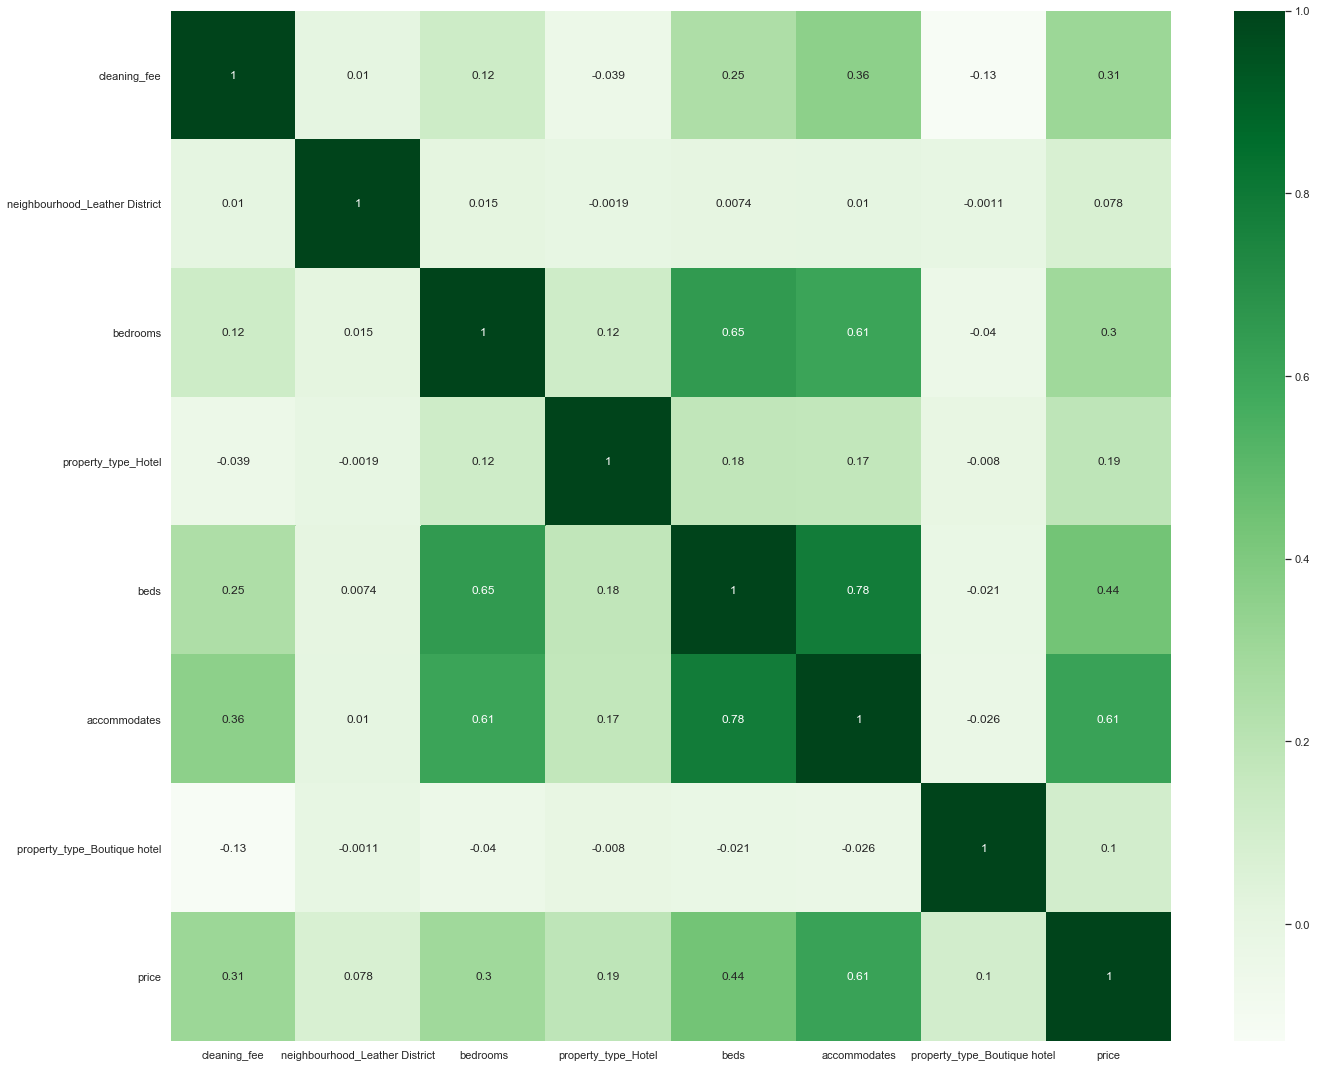

In [34]:
sns.set(style="whitegrid")
# Set figure layout 
f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(DF_train_dm.corr(), annot=True,cmap='Greens')
plt.tight_layout()

In [23]:
DF_train_dm = DF_train_dm[correlation_gd.index].copy()
print(DF_train_dm.shape)

(3784, 8)


In [24]:
continuous = DF_train_dm.iloc[:,:25].columns

In [25]:
for i in continuous:
    DF_train_dm[i] = np.log1p(DF_train_dm[i])

In [26]:
DF_train_log_mm = DF_train_dm.copy()
for i in continuous:
    DF_train_log_mm[i] = (DF_train_log_mm[i] - DF_train_log_mm[i].min())/(DF_train_log_mm[i].max() - DF_train_log_mm[i].min())

DF_train_log_mm.head()

,cleaning_fee,neighbourhood_Leather District,bedrooms,property_type_Hotel,beds,accommodates,property_type_Boutique hotel,price
0,0.696639,0.0,0.26265,0.0,0.000000,0.149726,0.0,0.525087
1,0.661273,0.0,0.26265,0.0,0.221065,0.149726,0.0,0.541082
2,0.706889,0.0,0.26265,0.0,0.221065,0.338358,0.0,0.557606
3,0.888821,0.0,0.26265,0.0,0.221065,0.149726,0.0,0.499995
4,0.888821,0.0,0.26265,0.0,0.221065,0.149726,0.0,0.544738


In [27]:
DF_train_log_std = DF_train_dm.copy()
for i in range(DF_train_log_std.shape[1]):
    DF_train_log_std.iloc[:,i] = (DF_train_log_std.iloc[:,i] - DF_train_log_std.iloc[:,i].mean()) / DF_train_log_std.iloc[:,i].std()
DF_train_log_std.head()

,cleaning_fee,neighbourhood_Leather District,bedrooms,property_type_Hotel,beds,accommodates,property_type_Boutique hotel,price
0,0.485780,-0.016251,-0.174975,-0.115662,-2.417454,-0.554931,-0.069153,-0.072068
1,0.362324,-0.016251,-0.174975,-0.115662,-0.604458,-0.554931,-0.069153,0.134981
2,0.521557,-0.016251,-0.174975,-0.115662,-0.604458,0.619664,-0.069153,0.348869
3,1.156640,-0.016251,-0.174975,-0.115662,-0.604458,-0.554931,-0.069153,-0.396870
4,1.156640,-0.016251,-0.174975,-0.115662,-0.604458,-0.554931,-0.069153,0.182305


In [28]:
from sklearn.model_selection import train_test_split

X_train = DF_train_dm.drop('price',axis = 1)
y_train = DF_train_dm['price']

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2, random_state=42)

In [29]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression(fit_intercept = True)
LR_model.fit(X_train, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
LR_model.coef_

array([ 0.04935692,  4.53134435, -0.15791855,  0.79526719, -0.16918779,
        1.12963884,  2.49625912])

In [31]:
prediction = np.exp(LR_model.predict(X_test))-1
prediction

array([152.74019072, 116.23547442, 267.14751164, 121.59134175,
       119.37825184,  54.95064581, 260.55620215, 173.20742518,
       177.57535138, 113.30567404, 177.57535138, 121.20642004,
       269.38465144,  66.93373817, 242.38219987,  61.42281136,
        64.45277791, 113.30567404, 254.27816489, 251.0560858 ,
       173.05394692, 121.20642004,  70.67252431,  78.71417958,
       498.34826326, 211.76152009, 240.19993723,  87.45545692,
       121.59134175,  97.57038235, 105.85460421, 157.90079235,
       105.85460421, 178.40158904, 108.81338924,  65.28482708,
       109.2689736 , 109.80604103, 146.07576096, 229.30929243,
        87.45545692, 176.66820471, 196.32058916, 112.16040879,
        74.40704706, 222.44815863, 144.03382612,  81.59088863,
       174.41663125, 151.52504819, 147.64170886, 171.73479715,
       105.85460421, 105.85460421, 232.71572469, 231.94936576,
        87.45545692,  95.99980676,  87.45545692, 274.59937682,
       158.41625456, 171.73479715, 314.75718748, 151.52

In [32]:
import statsmodels.api as sm

LR_sm_model = sm.OLS(y_train,sm.add_constant(X_train)).fit()
print(LR_sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     341.2
Date:                Fri, 18 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:45:09   Log-Likelihood:                -2377.0
No. Observations:                3027   AIC:                             4770.
Df Residuals:                    3019   BIC:                             4818.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [33]:
np.exp(LR_sm_model.predict(sm.add_constant(X_test)))-1

1597    152.740191
3096    116.235474
1574    267.147512
468     121.591342
780     119.378252
           ...    
3834     54.950646
1303    106.400187
1063     66.205861
3297    293.220771
1448    121.206420
Length: 757, dtype: float64